# Market Regime using Hidden Markov Model

In [ ]:
!pip install ta hmmlearn quantstats

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# technical analysis indicators
from ta import add_all_ta_features
from sklearn.ensemble import RandomForestClassifier
# Hidden Markov Models
from hmmlearn import hmm
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
import datetime
# Strategy performance metrics
import quantstats as qs
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="Model is not converging*")

# Getting the Data

In [3]:
def get_data(ticker, start_date, end_date):
    df = yf.download(ticker,start=start_date, end=end_date, auto_adjust=False, group_by=ticker)[ticker]
    df['returns'] = df['Adj Close'].pct_change()
    return df

### Technical Indicators

In [4]:
def technical_indicators(data_df):
    """
    Generates technical indicators from OHLCV data
    and removes raw price columns.
    """
    # Prepare OHLCV input for ta library
    df_ta_input = pd.DataFrame(index=data_df.index)
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        df_ta_input[col] = data_df[col].astype(float)

    # Generate all technical indicators
    ta_features = add_all_ta_features(
        df_ta_input,
        open="Open",
        high="High",
        low="Low",
        close="Close",
        volume="Volume",
        fillna=True
    )

    # Remove raw OHLCV columns
    ta_features = ta_features.drop(
        columns=["Open", "High", "Low", "Close", "Volume"],
        errors="ignore"
    )

    return ta_features

### Stationary

In [5]:
def make_stationary(feature_df, min_samples=20, alpha=0.05):
    """
    Applies ADF test to each feature and makes non-stationary
    series stationary using percentage change.
    """
    stationary_df = feature_df.copy()

    to_pct_change = []
    to_drop = []

    for col in stationary_df.columns:
        series = stationary_df[col].replace([np.inf, -np.inf], np.nan).dropna()

        # Not enough data
        if len(series) < min_samples:
            to_drop.append(col)
            continue

        try:
            pvalue = adfuller(series, regression="c", autolag="AIC")[1]
        except Exception:
            to_drop.append(col)
            continue

        if np.isnan(pvalue):
            to_drop.append(col)
        elif pvalue > alpha:
            to_pct_change.append(col) # Passed the test.

    # Make non-stationary series stationary
    stationary_df[to_pct_change] = stationary_df[to_pct_change].pct_change() # Passing Indicators and percent changes.

    # Drop unusable indicators
    stationary_df.drop(columns=to_drop, inplace=True, errors="ignore")

    return stationary_df


# Feature Engineering

In [6]:
def engineer_features(data_df, num_lead):
    ta_features = technical_indicators(data_df)
    stationary_features = make_stationary(ta_features)

    data_with_features = pd.concat(
        [data_df, stationary_features], axis=1)

    data_with_features["y_signal"] = np.where(
        data_with_features["returns"].shift(-num_lead) > 0, 1, 0) # Is the return positive(1) or negative(0)?

    feature_columns = stationary_features.columns.tolist()

    return data_with_features, feature_columns

# Hidden Markov Model

In [15]:
def detect_regime_hmm(returns, window=500):
    """
    Detects the current market regime using HMM.
    Uses only past returns → no lookahead.
    """
    returns_window = returns[-window:].dropna()

    if len(returns_window) < 50:
        return None

    X = returns_window.values.reshape(-1, 1)

    model = hmm.GaussianHMM(
    n_components=2,
    covariance_type="diag",
    n_iter=200,
    tol=1e-4,
    random_state=42
)
    model.fit(X)

    states = model.predict(X)
    return states[-1]  # current regime


## Signal Generation

In [8]:
def regime_based_signal(data, regime):
    """
    Very simple regime-based logic.
    Replace later with real strategies.
    """
    if regime is None:
        return 0

    recent_return = data['returns'].iloc[-1]

    if regime == 0:  # trend
        return 1 if recent_return > 0 else -1
    else:            # range
        return -1 if recent_return > 0 else 1


## Backtest

In [9]:
def run_backtest_simple(data_df, start_date_str,window_size=4*252):
    data_df = data_df.copy()
    data_df["signal"] = 0

    start_date = pd.to_datetime(start_date_str)
    start_idx = max(window_size,
        data_df.index.get_loc(data_df.index[data_df.index >= start_date][0]))

    for t in range(start_idx, len(data_df)):
        past_data = data_df.iloc[t-window_size:t]

        # Regime detection
        regime = detect_regime_hmm(past_data["returns"])

        # Strategy decision
        signal = regime_based_signal(past_data, regime)

        data_df.iloc[t, data_df.columns.get_loc("signal")] = signal

        if t % 200 == 0:
            print(f"{data_df.index[t].date()} | Regime: {regime} | Signal: {signal}")

    return data_df


## Plotting Results

In [10]:
def plot_results(results_df, ticker):
    """Plots cumulative returns."""
    # Check if the results DataFrame is empty
    if results_df.empty:
        print(f"No results to plot for {ticker}.")
        return

    # Calculate cumulative returns for a Buy-and-Hold strategy
    results_df['bh_cum_rets'] = (1 + results_df['returns']).cumprod()
    # Calculate strategy returns by multiplying daily returns with the trading signal
    results_df['strategy_returns'] = results_df['returns'] * results_df['signal']
    results_df.dropna(subset=['strategy_returns'], inplace=True)

    # Check if there are any valid returns left to plot
    if results_df.empty or results_df['strategy_returns'].isnull().all():
        print(f"No valid strategy returns to plot for {ticker} after processing.")
        return

    # Calculate cumulative returns for the HMM-RF strategy
    results_df['strategy_cum_rets'] = (1 + results_df['strategy_returns']).cumprod()

    # Create the plot
    plt.figure(figsize=(15, 7))
    plt.plot(results_df['bh_cum_rets'], label="Buy-and-Hold")
    plt.plot(results_df['strategy_cum_rets'], label="HMM-RF Strategy")
    plt.title(f'{ticker} Strategy Cumulative Returns', fontsize=16)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Cumulative Returns', fontsize=15)
    plt.tick_params(axis='both', labelsize=15)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

## Performance Statistics

In [19]:
def compute_perf_stats(results_to_plot):
    strategy_rets = results_to_plot['strategy_returns'].dropna()
    bh_rets = results_to_plot['returns'].loc[strategy_rets.index]

    stats = pd.DataFrame({
        "Buy & Hold": {
            "Annual return": qs.stats.cagr(bh_rets),
            "Cumulative returns": qs.stats.comp(bh_rets),
            "Annual volatility": qs.stats.volatility(bh_rets),
            "Sharpe ratio": qs.stats.sharpe(bh_rets),
            "Sortino ratio": qs.stats.sortino(bh_rets),
            "Max drawdown": qs.stats.max_drawdown(bh_rets),
            "Calmar ratio": qs.stats.calmar(bh_rets),
        },
        "Strategy": {
            "Annual return": qs.stats.cagr(strategy_rets),
            "Cumulative returns": qs.stats.comp(strategy_rets),
            "Annual volatility": qs.stats.volatility(strategy_rets),
            "Sharpe ratio": qs.stats.sharpe(strategy_rets),
            "Sortino ratio": qs.stats.sortino(strategy_rets),
            "Max drawdown": qs.stats.max_drawdown(strategy_rets),
            "Calmar ratio": qs.stats.calmar(strategy_rets),
        }
    })

    # Pretty print
    for row in stats.index:
        if row in ["Annual return", "Cumulative returns", "Annual volatility", "Max drawdown"]:
            stats.loc[row] = stats.loc[row].apply(lambda x: f"{x*100:.2f}%")
        else:
            stats.loc[row] = stats.loc[row].apply(lambda x: f"{x:.2f}")

    print(stats)


# Results

In [30]:
import logging

logging.getLogger("hmmlearn").setLevel(logging.ERROR)

[*********************100%***********************]  1 of 1 completed


Data loaded: 2191 rows
2025-06-24 | Regime: 0 | Signal: 1


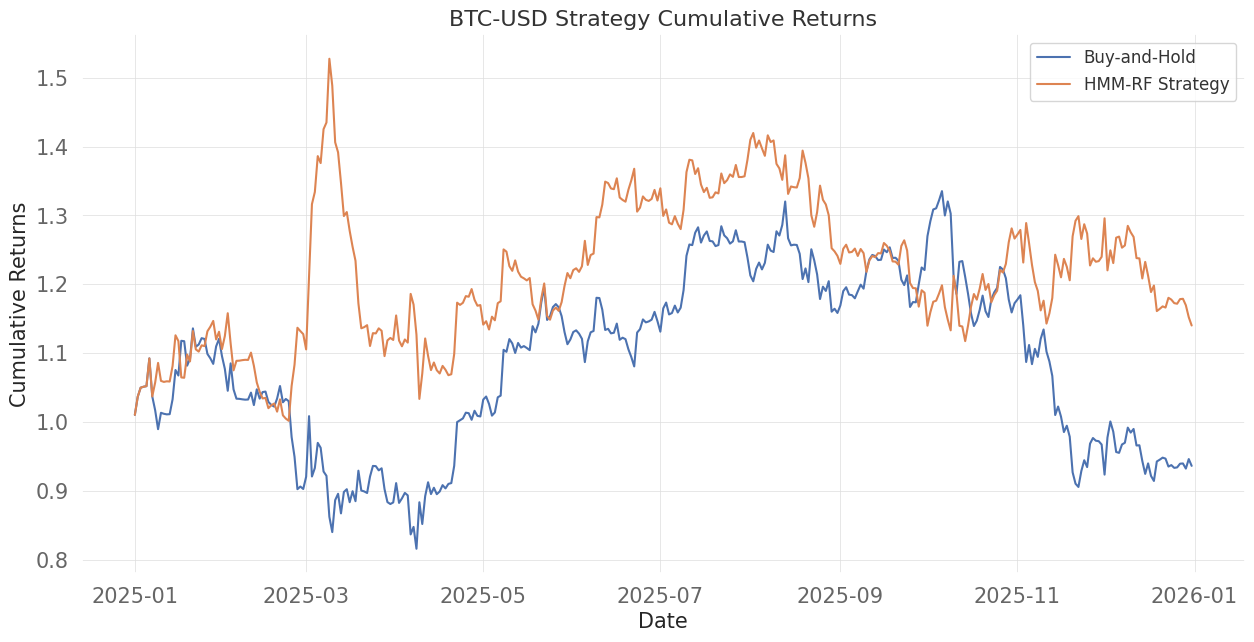

                   Buy & Hold Strategy
Annual return          -4.42%    9.49%
Cumulative returns     -6.34%   14.03%
Annual volatility      34.83%   34.82%
Sharpe ratio             0.04     0.43
Sortino ratio            0.06     0.66
Max drawdown          -32.15%  -32.32%
Calmar ratio            -0.14     0.29


/tmp/ipython-input-1971074700.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-4.42%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats.loc[row] = stats.loc[row].apply(lambda x: f"{x*100:.2f}%")
/tmp/ipython-input-1971074700.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.49%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats.loc[row] = stats.loc[row].apply(lambda x: f"{x*100:.2f}%")


In [32]:
# Parameters
TICKER = "BTC-USD"
START_DATE = "2020-01-01"
END_DATE = "2026-01-01"
BACKTEST_SIGNAL_START_DATE = "2025-01-01"

raw_data = get_data(TICKER, START_DATE, END_DATE)

# Safety check
if raw_data.empty:
    raise ValueError("No data downloaded.")

# Ensure returns exist
if "returns" not in raw_data.columns:
    raw_data["returns"] = raw_data["Close"].pct_change()

raw_data.dropna(subset=["returns"], inplace=True)

print(f"Data loaded: {raw_data.shape[0]} rows")

#Run Simplified Regime-Based Backtest ---
results_df = run_backtest_simple(
    data_df=raw_data.copy(),
    start_date_str=BACKTEST_SIGNAL_START_DATE,
    window_size=4 * 252)

# Filter results for evaluation period ---
results_to_plot = results_df[
    results_df.index >= pd.to_datetime(BACKTEST_SIGNAL_START_DATE)].copy()

if results_to_plot.empty:
    raise ValueError("No results available after start date.")

# Plot cumulative returns ---
plot_results(results_to_plot, TICKER)

# Print performance statistics ---
compute_perf_stats(results_to_plot)
